# Neighbourhood Classification 

## 1. Introduction/Aim

The aim of this project is to find neighbourhoods in a new unkown city similar to neighbourhoods in a known city in order to choose a neighbourhood to live in, but can be also useful for companies to investigate e.g. where to open a certain type of venue based on the neighbourhood data of a successful venue of the same type in another city.

In this particular project I will use the data from popular Frankfurt am Main (Ffm) neighbourhoods to find similar neighbourhoods in Zürich. 

## 2. Data

I will use FourSquare Data to find the characteristic venue profile for popular Frankfurt neigbourhoods e.g. Nordend and Bornheim (favourite) as well as for not so popular neighbourhoods e.g. Bonames and Niederrad (boring) in order to build a model to classify neighbourhoods. I will use the same type of data for Zürich neighbourhoods (Kreis 1-12) to feed the data into the model and classify the Zürich neighbourhoods into "favourite" and "boring". 
For this I will focus on criteria that are important for the choice of a neighbourhood to live in:

- number of certain venue types and their rating
- number of different venue categories per neighbourhood (diversity of venues in neighbourhood)
- distance to important venue types (e.g. central train station)

The longitude and latitude data for the neighbourhoods will be extracted from the wikipedia page of the neighbourhoods.


In [292]:
### import libraries needed  ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import wikipedia

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 

# library to handle requests
import requests 
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# import sklearn functions
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  

# map rendering library
import folium 

print('Libraries imported.')

Libraries imported.


In [587]:
# Define 4 Square Credentials
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET = # your Foursquare Secret
VERSION = '20190530'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

### 2.1 Get coordinates of neighbourhoods from the wikipedia page of the neighbourhoods

In [294]:
# importing modules 
import requests 
from bs4 import BeautifulSoup
from lxml import etree 


In [295]:
# coordinates of known neigbourhoods in Amsterdam, Berlin, Bonn, Frankfurt, Rotterdam, Wuppertal
Names_neighbourhoods = ('Nieuwmarkt','Burgwallen_Oude_Zijde','Alexanderplatz','Berlin-Friedrichshain','Berlin-Kreuzberg','Hardtberg','Stadionbuurt','Bullewijk','Jordaan','De_Pijp','Hoek_van_Holland','Delfshaven','Auerberg','Röttgen_(Bonn)','Tannenbusch','Südstadt_(Bonn)','Poppelsdorf','Bad_Godesberg','Ölberg_(Wuppertal)','Luisenstraße_(Wuppertal)','Frankfurt-Westend', 'Frankfurt-Nordend', 'Frankfurt-Bornheim','Frankfurt-Sachsenhausen', 'Frankfurt-Niederrad', 'Frankfurt-Schwanheim', 'Frankfurt-Hausen', 'Frankfurt-Bonames', 'Frankfurt-Niederursel', 'Frankfurt-Bergen-Enkheim', 'Frankfurt-Kalbach-Riedberg')
Cities = ( 'Amsterdam','Amsterdam','Berlin','Berlin','Berlin','Bonn', 'Amsterdam', 'Amsterdam', 'Amsterdam','Amsterdam','Rotterdam','Rotterdam', 'Bonn', 'Bonn', 'Bonn', 'Bonn', 'Bonn','Bonn', 'Wuppertal', 'Wuppertal','Frankfurt','Frankfurt','Frankfurt','Frankfurt','Frankfurt','Frankfurt','Frankfurt','Frankfurt','Frankfurt')
Labels_neighbourhoods = ('too busy','too busy','too busy','favourite','favourite','boring','boring','boring','favourite','favourite','boring','favourite','boring','boring','boring','favourite','favourite','boring','favourite','favourite','favourite','favourite','favourite','favourite','boring', 'boring','boring','boring','boring','boring')

wikipedia.set_lang('de')

lat_ = []
long_ = []

for neighbourhood in Names_neighbourhoods:
    district_page=wikipedia.WikipediaPage(neighbourhood, pageid=None, redirect=True, preload=False, original_title=u'')
    lat_.append(district_page.coordinates[0])
    long_.append(district_page.coordinates[1])

In [296]:
# make dataframe with neighbourhood names and coordinates as well as labels    
zippedList=list(zip(Cities,Names_neighbourhoods, lat_, long_, Labels_neighbourhoods))

data = pd.DataFrame(zippedList,columns =['City','Neighbourhood', 'Latitude', 'Longitude', 'Label'])

data.head()

,City,Neighbourhood,Latitude,Longitude,Label
0,Amsterdam,Nieuwmarkt,52.3725650000000015893419913481920957565307617...,4.900339999999999918145476840436458587646484375,too busy
1,Amsterdam,Burgwallen_Oude_Zijde,52.3706900000000032946445571724325418472290039...,4.89464400000000043888803702429868280887603759...,too busy
2,Berlin,Alexanderplatz,52.521944439999998621715349145233631134033203125,13.4130555600000000993077264865860342979431152...,too busy
3,Berlin,Berlin-Friedrichshain,52.5158333299999995347207004670053720474243164...,13.4541666699999993284109223168343305587768554...,favourite
4,Berlin,Berlin-Kreuzberg,52.4874999999999971578290569595992565155029296875,13.383333329999999250503606162965297698974609375,favourite


In [298]:
## function to get nearby venues

def getNearbyVenues(neighbourhood_names, latitudes, longitudes,  radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(neighbourhood_names, latitudes, longitudes):
        
        # create API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            lat, lng, 
            VERSION, 
            radius, 
            LIMIT)
    
        # get request
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        try:
            rating = (results['response']['venue']['rating'])
        except:
            rating =('This venue has not been rated yet.')

    
        # get venue data
        venues_list.append([(    
        name,
        v['venue']['name'],
        rating,    
        v['venue']['categories'][0]['name'])    
        for v in results])
    
    # make dataframe with all the important data
    nearby = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby.columns= ['Neighbourhood',
                     'Venue Name','Venue Rating', 'Venue Category']
    
    return(nearby)

In [299]:
venues = getNearbyVenues(neighbourhood_names=data['Neighbourhood'], 
                                    latitudes=data['Latitude'],
                                    longitudes= data['Longitude'],
                                    radius=500)

venues.head(10)

,Neighbourhood,Venue Name,Venue Rating,Venue Category
0,Nieuwmarkt,Rosalia's Menagerie,This venue has not been rated yet.,Cocktail Bar
1,Nieuwmarkt,De Koffieschenkerij,This venue has not been rated yet.,Coffee Shop
2,Nieuwmarkt,OCHA,This venue has not been rated yet.,Thai Restaurant
3,Nieuwmarkt,Excalibur,This venue has not been rated yet.,Bar
4,Nieuwmarkt,Latei,This venue has not been rated yet.,Café
5,Nieuwmarkt,Nieuwmarkt,This venue has not been rated yet.,Plaza
6,Nieuwmarkt,Eetcafé Bern,This venue has not been rated yet.,Swiss Restaurant
7,Nieuwmarkt,Record Friend,This venue has not been rated yet.,Record Shop
8,Nieuwmarkt,YoYo! Fresh Tea Bar,This venue has not been rated yet.,Tea Room
9,Nieuwmarkt,Mata Hari,This venue has not been rated yet.,Mediterranean Restaurant



### 2.3 Numbers of different venues by category per neighbourhood
  
  

In [300]:
one_hot = pd.get_dummies(venues['Venue Category'])
one_hot['Neighbourhood'] = venues['Neighbourhood'] 

N_categ=one_hot.groupby('Neighbourhood').sum().reset_index()

N_categ

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Apple Wine Pub,Arcade,Argentinian Restaurant,Art Gallery,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio
0,Alexanderplatz,0,0,0,0,0,0,0,0,0,...,0,1,3,0,0,0,0,0,0,0
1,Auerberg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bad_Godesberg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Berlin-Friedrichshain,0,0,0,1,1,0,0,0,0,...,0,3,4,0,0,0,0,0,0,0
4,Berlin-Kreuzberg,0,1,0,0,0,0,0,0,0,...,0,1,1,1,0,0,0,0,0,1
5,Bullewijk,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
6,Burgwallen_Oude_Zijde,0,0,0,0,1,0,0,1,1,...,0,0,0,0,0,0,1,0,1,0
7,De_Pijp,1,0,0,0,0,0,0,0,0,...,0,3,1,0,0,0,1,1,0,1
8,Delfshaven,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
9,Frankfurt-Bonames,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [301]:
# find number of different venues types per neighbourhood to assess diversity

N_categ['Diversity'] = N_categ.astype(bool).sum(axis=1)

N_categ.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Apple Wine Pub,Arcade,Argentinian Restaurant,Art Gallery,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Diversity
0,Alexanderplatz,0,0,0,0,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,62
1,Auerberg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2,Bad_Godesberg,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,36
3,Berlin-Friedrichshain,0,0,0,1,1,0,0,0,0,...,3,4,0,0,0,0,0,0,0,45
4,Berlin-Kreuzberg,0,1,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,1,33




### 2.4 Finding the distance to important venue types

In this example I will use the distance to the central train station of city as well as the distance to the central public library. The coordinates are again extracted from the wikipedia pages.


In [302]:
# distance to central station and public library (using haversine function)
#!conda install -c conda-forge haversine --yes 
from haversine import haversine, Unit

wikipedia.set_lang('de')

# coordinates central station
hbf_Ffm=(wikipedia.WikipediaPage('Frankfurt_(Main)_Hauptbahnhof', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates
hbf_A=(wikipedia.WikipediaPage('Amsterdam_Centraal', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates
hbf_BN=(wikipedia.WikipediaPage('Bonn_Hauptbahnhof', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates
hbf_W=(wikipedia.WikipediaPage('Wuppertal_Hauptbahnhof', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates
hbf_B=(wikipedia.WikipediaPage('Berlin_Hauptbahnhof', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates
hbf_R=(wikipedia.WikipediaPage('Rotterdam_Centraal', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates


# coordinates public library 
lib_Ffm= (wikipedia.WikipediaPage('Stadtbücherei_Frankfurt_am_Main', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates
lib_B= (wikipedia.WikipediaPage('Berliner_Stadtbibliothek', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates
lib_BN= (wikipedia.WikipediaPage('Stadtbibliothek_Bonn', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates
lib_W= (wikipedia.WikipediaPage('Stadtbibliothek_Wuppertal', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates

# switch to english website since german websites do not exist
wikipedia.set_lang('en')
lib_A= (wikipedia.WikipediaPage('Openbare_Bibliotheek_Amsterdam', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates
lib_R= (wikipedia.WikipediaPage('Central_Library_of_Rotterdam', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates


dist_hbf = []
dist_lib = []

# get distance of each neigbourhood to central station and add as new column to dataframe
for neighbourhood in range(0,len(data)):
    if Cities[neighbourhood] == 'Amsterdam':
        dist_hbf.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], hbf_A))
        dist_lib.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], lib_A))
    if Cities[neighbourhood] == 'Rotterdam':
        dist_hbf.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], hbf_R))
        dist_lib.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], lib_R)) 
    if Cities[neighbourhood] == 'Bonn':
        dist_hbf.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], hbf_BN))
        dist_lib.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], lib_BN))  
    if Cities[neighbourhood] == 'Berlin':
        dist_hbf.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], hbf_B))
        dist_lib.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], lib_B))
    if Cities[neighbourhood] == 'Frankfurt':
        dist_hbf.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], hbf_Ffm))
        dist_lib.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], lib_Ffm))
    if Cities[neighbourhood] == 'Wuppertal':
        dist_hbf.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], hbf_W))
        dist_lib.append(haversine([data['Latitude'][neighbourhood], data['Longitude'][neighbourhood]], lib_W))
              
    
data['dist_hbf']= dist_hbf    
data['dist_lib']= dist_lib
data.head()

,City,Neighbourhood,Latitude,Longitude,Label,dist_hbf,dist_lib
0,Amsterdam,Nieuwmarkt,52.3725650000000015893419913481920957565307617...,4.900339999999999918145476840436458587646484375,too busy,0.641788,0.591904
1,Amsterdam,Burgwallen_Oude_Zijde,52.3706900000000032946445571724325418472290039...,4.89464400000000043888803702429868280887603759...,too busy,0.924373,1.027720
2,Berlin,Alexanderplatz,52.521944439999998621715349145233631134033203125,13.4130555600000000993077264865860342979431152...,too busy,2.970014,0.932227
3,Berlin,Berlin-Friedrichshain,52.5158333299999995347207004670053720474243164...,13.4541666699999993284109223168343305587768554...,favourite,5.822209,3.385593
4,Berlin,Berlin-Kreuzberg,52.4874999999999971578290569595992565155029296875,13.383333329999999250503606162965297698974609375,favourite,4.274460,3.422634


In [303]:
## merge venue data with rest of data

data = data.merge(N_categ, on='Neighbourhood')
data = data.drop(['Latitude', 'Longitude'], axis=1)


# save data as csv

data.to_csv('data.csv')
data.head()

,City,Neighbourhood,Label,dist_hbf,dist_lib,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Diversity
0,Amsterdam,Nieuwmarkt,too busy,0.641788,0.591904,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,57
1,Amsterdam,Burgwallen_Oude_Zijde,too busy,0.924373,1.027720,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,62
2,Berlin,Alexanderplatz,too busy,2.970014,0.932227,0,0,0,0,0,...,1,3,0,0,0,0,0,0,0,62
3,Berlin,Berlin-Friedrichshain,favourite,5.822209,3.385593,0,0,0,1,1,...,3,4,0,0,0,0,0,0,0,45
4,Berlin,Berlin-Kreuzberg,favourite,4.274460,3.422634,0,1,0,0,0,...,1,1,1,0,0,0,0,0,1,33


In [139]:
## load csv file

#data = pd.read_csv('data.csv')
#data.head()

## 3. Methods

### 3.1 Classification Tree using Random Forest

- predicts that on observation belongs to the most commonly occuring class of training observation in the region to which it belongs.

- Gini index as measure for node purity and evaluate a split: measures variance across all K classes -> the smaller the purer the node
       
    
To improve predictive accuracy I use the random forest algorithm in which mulitple decision trees are build on bootstrapped data and for each step in tree building only a random subset of predictors (features) is used. 


In [402]:
from sklearn.ensemble import RandomForestClassifier

# split data into train and test data

X = data.drop(['Label', 'City', 'Neighbourhood'], axis = 1)
Y = data['Label']

# test data 30% of full data set

X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3, random_state = 50)

In [588]:
# determine number of trees in random forest based on average accuracy from 20 different train and test data splits (cross-validation)

counter=0
all_accuracy_RF =np.zeros(149)

while counter<20:
    counter+=1
    # test data 30% of full data set
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3, random_state = 50)
    accuracy_RF=[]

    for i in range(1,150):
        classifier = RandomForestClassifier(n_estimators=i)
        classifier.fit(X_train, y_train)
        y_predict = classifier.predict(X_test) 
    
    
        confusion_matrix(y_test, y_predict)
        report=classification_report(y_test, y_predict, output_dict=True)
        accuracy_RF.append(report['accuracy'])
    
    all_accuracy_RF=np.vstack([all_accuracy_RF,accuracy_RF])
    
    

In [425]:
mean_accuracy=all_accuracy_RF[1:][:].mean(axis=0)
std_accuracy=all_accuracy_RF[1:][:].std(axis=0)

<ErrorbarContainer object of 3 artists>

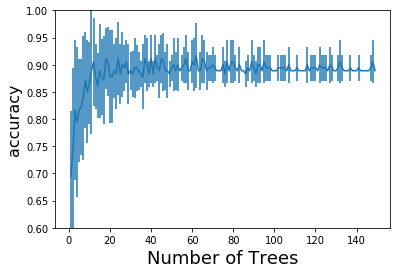

In [436]:
## plot development of accuracy with different number of Trees in forests

plt.xlabel('Number of Trees', fontsize=18)
plt.ylabel('accuracy', fontsize=16)
plt.ylim([0.6,1])
plt.errorbar(np.arange(1,150),mean_accuracy,xerr=std_accuracy, yerr=std_accuracy)

For the RF model I will choose a number of 70 trees, since for this number the accuracy and the standarddeviation are stablised  

In [443]:
classifier_RF = RandomForestClassifier(n_estimators=70)
classifier_RF.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Visualisation of on example tree

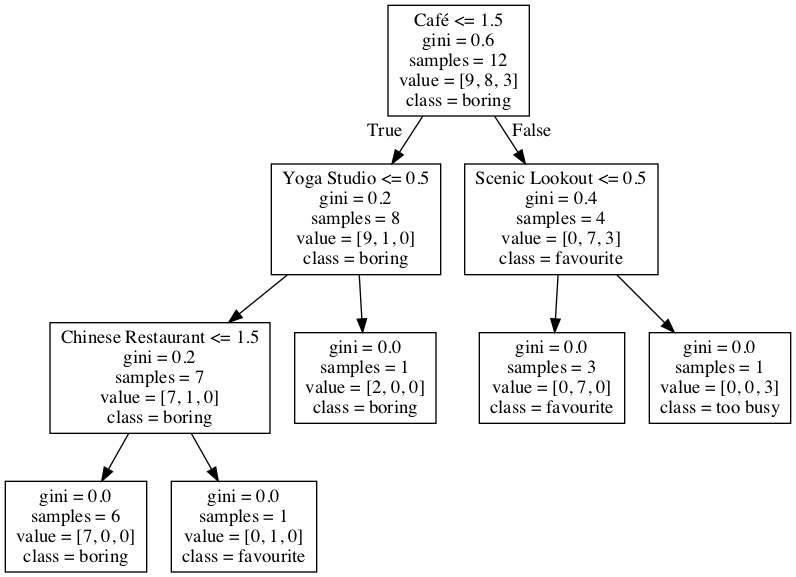

In [444]:
from sklearn import tree
from IPython.display import Image  
#!conda install -c conda-forge pydotplus --yes 
import pydotplus

# show one of the trees
treeR = classifier_RF.estimators_[1]

dot_data=export_graphviz(treeR, out_file =None, 
                 feature_names=X.columns,class_names=classifier.classes_, precision=1)

graph =pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())


### Get Feature importance 

The importance of a feature is estimated by its mean decrease in gini index across all the trees in the forest




In [445]:
# extract importances
importances = list(classifier.feature_importances_)

# make list of features and importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X.columns, importances)]

# sort features by importance
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# print list
[print('Feature: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]


Feature: dist_lib             Importance: 0.09
Feature: Cocktail Bar         Importance: 0.07
Feature: Italian Restaurant   Importance: 0.05
Feature: dist_hbf             Importance: 0.04
Feature: Café                 Importance: 0.04
Feature: Vietnamese Restaurant Importance: 0.04
Feature: Diversity            Importance: 0.04
Feature: Bar                  Importance: 0.03
Feature: Hotel                Importance: 0.03
Feature: Pub                  Importance: 0.03
Feature: Burger Joint         Importance: 0.02
Feature: Gym / Fitness Center Importance: 0.02
Feature: Park                 Importance: 0.02
Feature: Thai Restaurant      Importance: 0.02
Feature: Asian Restaurant     Importance: 0.01
Feature: Bakery               Importance: 0.01
Feature: Bowling Alley        Importance: 0.01
Feature: Brewery              Importance: 0.01
Feature: Bus Stop             Importance: 0.01
Feature: Candy Store          Importance: 0.01
Feature: Chinese Restaurant   Importance: 0.01
Feature: Cof

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

Text(0.5, 1.0, 'Features with Importances >0')

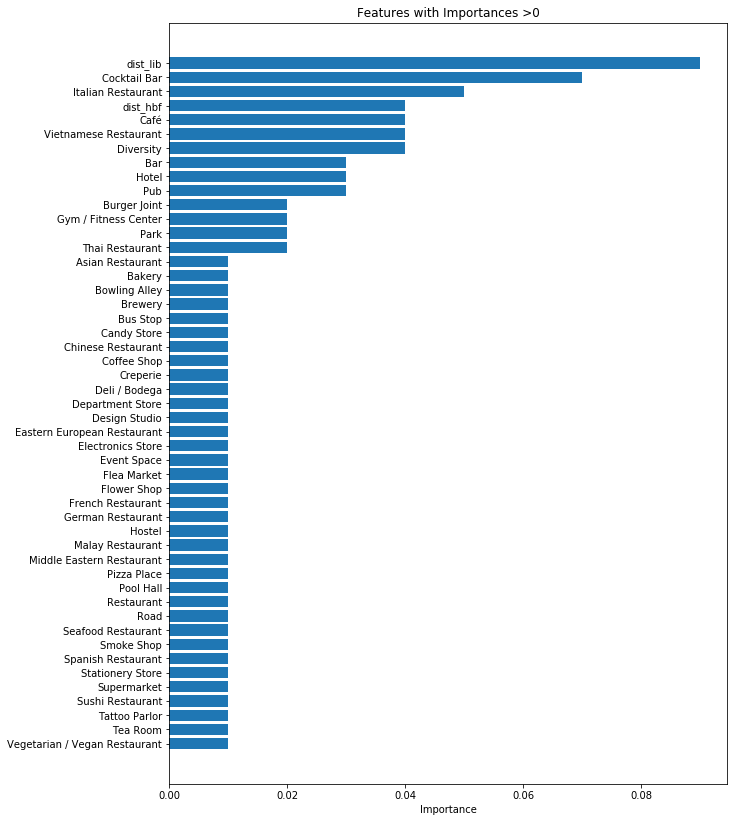

In [547]:
feature_import_value=[]
feature_import_names=[]

for i in range(0,49):
    feature_import_value.append(feature_importances[i][1])
    feature_import_names.append(feature_importances[i][0])

fig     
fig, ax = plt.subplots(figsize=(10, 14))

y_pos = np.arange(len(feature_import_value))

ax.barh(y_pos, feature_import_value, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(feature_import_names)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Importance')
ax.set_title('Features with Importances >0')



### 3.2 K-nearest neighbour

In [446]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier

In [447]:
## Since we use euclidean distance to classify the data we need to normalise it
## https://www.dataquest.io/blog/k-nearest-neighbors-in-python/

X_norm = (X - X.mean())/X.std()

X_norm.head()

,dist_hbf,dist_lib,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Apple Wine Pub,Arcade,Argentinian Restaurant,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Diversity
0,-0.795231,-0.725510,-0.185695,-0.185695,-0.185695,-0.185695,-0.267432,-0.253881,5.199469,2.152785,...,-0.501871,-0.455051,-0.185695,-0.185695,5.199469,-0.554265,-0.267432,-0.267432,-0.393043,1.533964
1,-0.730519,-0.632887,-0.185695,-0.185695,-0.185695,-0.185695,3.610330,-0.253881,-0.185695,2.152785,...,-0.501871,-0.455051,-0.185695,-0.185695,-0.185695,1.741977,-0.267432,3.610330,-0.393043,1.796567
2,-0.262067,-0.653182,-0.185695,-0.185695,-0.185695,-0.185695,-0.267432,-0.253881,-0.185695,-0.448497,...,0.710983,2.590291,-0.185695,-0.185695,-0.185695,-0.554265,-0.267432,-0.267432,-0.393043,1.796567
3,0.391085,-0.131775,-0.185695,-0.185695,-0.185695,5.199469,3.610330,-0.253881,-0.185695,-0.448497,...,3.136691,3.605406,-0.185695,-0.185695,-0.185695,-0.554265,-0.267432,-0.267432,-0.393043,0.903717
4,0.036651,-0.123903,-0.185695,5.199469,-0.185695,-0.185695,-0.267432,-0.253881,-0.185695,-0.448497,...,0.710983,0.560063,5.199469,-0.185695,-0.185695,-0.554265,-0.267432,-0.267432,2.456518,0.273469


In [589]:
# determine accuracy of model with different Ks and for differnet train-test-data splits

counter=0
all_accuracy_KNN =np.zeros(19)

while counter<20:
    counter+=1
    # test data 30% of full data set
    X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.3, random_state = 50)
    accuracy_KNN=[]
    
    # get accuracy of model for different Ks
    
    for k in range(1,20):
        k_classifier = KNeighborsClassifier(n_neighbors=k, weights ='distance')
        k_classifier.fit(X_train, y_train)
    
        y_predict_k = k_classifier.predict(X_test)

        confusion_matrix(y_test, y_predict)
        report=classification_report(y_test, y_predict_k, output_dict=True)
        accuracy_KNN.append(report['accuracy'])
    all_accuracy_KNN=np.vstack([all_accuracy_KNN,accuracy_KNN])
    

(0, 1)

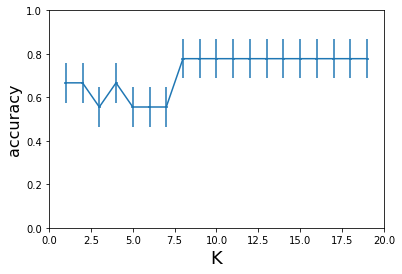

In [569]:
## plot development of accuracy with different "Ks"
std_accuracy_KNN=all_accuracy_KNN[1:][:].std()

plt.errorbar(np.arange(1,20),all_accuracy_KNN[1:][:].mean(axis=0),xerr=std_accuracy_KNN, yerr=std_accuracy_KNN )
plt.xlabel('K', fontsize=18)
plt.ylabel('accuracy', fontsize=16)
plt.ylim([0,1])


### 3.3 Improving classifier performance through feature reduction

Since I am using a lot of features (>200), reducing the number of features could improve the performance of the classifier.
For this I will discard all the features that got a 0 importance in the random forest model.



In [462]:
# extract all the features with am importance larger than 0
reduc_features=[]

for i in range(0,len(feature_importances)):
    if feature_importances[i][1]>0:
        reduc_features.append(feature_importances[i][0])

# select only important features        
X_norm_reduc = X_norm[reduc_features]        
X_norm_reduc.head()        

,dist_lib,Cocktail Bar,Italian Restaurant,dist_hbf,Café,Vietnamese Restaurant,Diversity,Bar,Hotel,Pub,...,Road,Seafood Restaurant,Smoke Shop,Spanish Restaurant,Stationery Store,Supermarket,Sushi Restaurant,Tattoo Parlor,Tea Room,Vegetarian / Vegan Restaurant
0,-0.725510,0.439799,-0.31746,-0.795231,0.174106,-0.455051,1.533964,2.679413,2.329360,0.799992,...,-0.267432,-0.448497,1.375364,-0.478326,-0.185695,-1.022513,1.464785,-0.185695,2.456518,-0.501871
1,-0.632887,1.599269,-0.31746,-0.730519,0.174106,-0.455051,1.796567,1.173541,3.163328,0.799992,...,-0.267432,2.152785,4.699160,-0.478326,-0.185695,-1.022513,-0.659153,5.199469,-0.393043,-0.501871
2,-0.653182,0.439799,-0.31746,-0.262067,-0.141461,2.590291,1.796567,-0.633505,2.329360,-0.564700,...,-0.267432,0.852144,-0.286534,0.908819,5.199469,1.095549,1.464785,-0.185695,-0.393043,0.710983
3,-0.131775,0.439799,-0.31746,0.391085,0.805242,3.605406,0.903717,0.270018,0.244439,4.211723,...,3.610330,-0.448497,-0.286534,-0.478326,-0.185695,1.095549,1.464785,-0.185695,2.456518,3.136691
4,-0.123903,1.599269,1.68392,0.036651,1.436378,0.560063,0.273469,-0.332330,-0.589529,-0.564700,...,-0.267432,-0.448497,-0.286534,-0.478326,-0.185695,-1.022513,-0.659153,-0.185695,2.456518,0.710983


In [570]:
#determine accuracy of model with different Ks and for differnet train-test-data splits with smaller feature space

counter=0
all_accuracy_KNN_reduc=np.zeros(19)

while counter<20:
    counter+=1
    X_train, X_test, y_train, y_test = train_test_split(X_norm_reduc,Y,test_size = 0.3, random_state = 100)
    accuracy = []

# get accuracy of model for different Ks
    for k in range(1,20):
        k_classifier = KNeighborsClassifier(n_neighbors=k,weights ='distance')
        k_classifier.fit(X_train, y_train)
    
        y_predict_k = k_classifier.predict(X_test)
        confusion_matrix(y_test, y_predict)
        report=classification_report(y_test, y_predict_k, output_dict=True)
        accuracy.append( report['accuracy'])
    
    all_accuracy_KNN_reduc=np.vstack([all_accuracy_KNN_reduc, accuracy])
    
    


accuracy: [0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 1.0, 0.8888888888888888, 1.0, 1.0, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778, 0.7777777777777778]


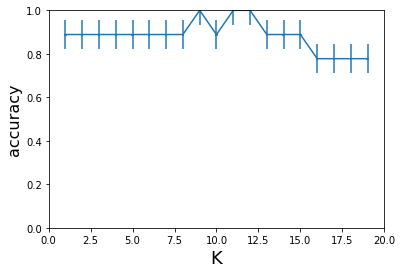

In [571]:
##plot development of accuracy with different "Ks"

plt.errorbar(np.arange(1,20),all_accuracy_KNN_reduc[1:][:].mean(axis=0), xerr=all_accuracy_KNN_reduc[1:][:].std(),yerr=all_accuracy_KNN_reduc[1:][:].std())
plt.xlabel('K', fontsize=18)
plt.ylabel('accuracy', fontsize=16)
plt.ylim([0,1])

print('accuracy:', accuracy)

Until K=9 the accuracy stays stable and for K=13 decreases again. For the model I will choose K=7, since smaller Ks could let to an overfitted model

In [580]:
# Use K= 7 to build classifier, neighbours are weighted by their distance to query point
k_classifier = KNeighborsClassifier(n_neighbors=7,weights ='distance')
k_classifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='distance')

## 4. Results: Predicting classes of Zürich neighbourhoods 

### 4.1 Get data of Zürich neighbourhoods

In [479]:
# coordinates of Z_neighbourhoods
# Zürich has 12 districts
wikipedia.set_lang('en')

lat_Z = []
long_Z = []
Names_neighbourhoods=[]


for i in range(1,13):
    district= str(i)
    title = "District_"+district+"_(Zürich)" 
    district_page=wikipedia.WikipediaPage(title, pageid=None, redirect=True, preload=False, original_title=u'')
    lat_Z.append(district_page.coordinates[0])
    long_Z.append(district_page.coordinates[1])
    Names_neighbourhoods.append('Kreis '+district)

In [480]:
# make dataframe with neighbourhood names and coordinates as well as labels  
zippedList=list(zip(Names_neighbourhoods, lat_Z, long_Z))

Z_data = pd.DataFrame(zippedList,columns =['Neighbourhood', 'Latitude', 'Longitude'])

Z_data_coord = Z_data
#Z_data.head()

In [481]:
# coordinates central station
wikipedia.set_lang('de')

hbf_Z=(wikipedia.WikipediaPage('Zürich_Hauptbahnhof', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates
lib_Z=(wikipedia.WikipediaPage('Zentralbibliothek_Zürich', pageid=None, redirect=True, preload=False, original_title=u'')).coordinates


dist_hbf_Z = []
dist_lib_Z =[]

# get distance of each neigbourhood to central station and add as new column to dataframe
for neighbourhood in range(0,len(Z_data)):
    dist_hbf_Z.append(haversine([Z_data['Latitude'][neighbourhood], Z_data['Longitude'][neighbourhood]], hbf_Z))
    dist_lib_Z.append(haversine([Z_data['Latitude'][neighbourhood], Z_data['Longitude'][neighbourhood]],lib_Z)) 
        
Z_data['dist_hbf']= dist_hbf_Z 
Z_data['dist_lib']= dist_lib_Z
Z_data.head()

,Neighbourhood,Latitude,Longitude,dist_hbf,dist_lib
0,Kreis 1,47.3699999999999974420461512636393308639526367...,8.54199999999999981525888870237395167350769042...,0.874542,0.524963
1,Kreis 2,47.3370000000000032969182939268648624420166015625,8.5210000000000007958078640513122081756591796875,4.761165,4.519313
2,Kreis 3,47.366666670000000749496393837034702301025390625,8.51666666999999932841092231683433055877685546875,2.165175,2.310397
3,Kreis 4,47.375,8.52699999999999924682470009429380297660827636...,1.046451,1.379461
4,Kreis 5,47.3879999999999981241671775933355093002319335...,8.5210000000000007958078640513122081756591796875,1.843531,2.389013


In [482]:
# get venues in Zürich Neighbourhoods
venues_Z = getNearbyVenues(neighbourhood_names=Z_data['Neighbourhood'], 
                                    latitudes=Z_data['Latitude'],
                                    longitudes= Z_data['Longitude'],
                                    radius=500)

venues_Z.head(10)

,Neighbourhood,Venue Name,Venue Rating,Venue Category
0,Kreis 1,Sprüngli,This venue has not been rated yet.,Dessert Shop
1,Kreis 1,Frauenbad Stadthausquai,This venue has not been rated yet.,Pool
2,Kreis 1,Zeughauskeller,This venue has not been rated yet.,Swiss Restaurant
3,Kreis 1,Ban Song Thai,This venue has not been rated yet.,Thai Restaurant
4,Kreis 1,Café Schober,This venue has not been rated yet.,Café
5,Kreis 1,Old Fashion Bar,This venue has not been rated yet.,Bar
6,Kreis 1,Münsterhof,This venue has not been rated yet.,Plaza
7,Kreis 1,Hermès,This venue has not been rated yet.,Boutique
8,Kreis 1,Old Crow,This venue has not been rated yet.,Cocktail Bar
9,Kreis 1,Schwarzenbach Kolonialwaren,This venue has not been rated yet.,Gourmet Shop


In [483]:
# different venue types
one_hot_Z = pd.get_dummies(venues_Z['Venue Category'])
one_hot_Z['Neighbourhood'] = venues_Z['Neighbourhood'] 

N_categ_Z=one_hot_Z.groupby('Neighbourhood').sum().reset_index()

# find number of different venues types per neighbourhood to assess diversity
N_categ_Z['Diversity'] = N_categ_Z.astype(bool).sum(axis=1)

N_categ_Z.head()

,Neighbourhood,Accessories Store,Antique Shop,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,Bakery,Bar,...,Thai Restaurant,Theater,Tibetan Restaurant,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Diversity
0,Kreis 1,0,0,1,1,2,0,0,1,5,...,2,0,0,0,1,0,0,0,2,45
1,Kreis 10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,Kreis 11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
3,Kreis 12,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,8
4,Kreis 2,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5


In [484]:
## merge venue data with rest of data

Z_data = Z_data.merge(N_categ_Z, on='Neighbourhood')
Z_data = Z_data.drop(['Latitude', 'Longitude'], axis=1)


# save data as csv

Z_data.to_csv('Zurich_data.csv')
Z_data.head()

,Neighbourhood,dist_hbf,dist_lib,Accessories Store,Antique Shop,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Automotive Shop,...,Thai Restaurant,Theater,Tibetan Restaurant,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Water Park,Wine Bar,Diversity
0,Kreis 1,0.874542,0.524963,0,0,1,1,2,0,0,...,2,0,0,0,1,0,0,0,2,45
1,Kreis 2,4.761165,4.519313,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
2,Kreis 3,2.165175,2.310397,0,1,0,0,0,0,0,...,1,0,0,0,2,0,1,0,0,24
3,Kreis 4,1.046451,1.379461,0,0,0,1,0,0,0,...,3,0,1,0,0,1,2,1,1,49
4,Kreis 5,1.843531,2.389013,1,0,0,2,0,2,1,...,1,1,0,1,1,0,0,0,0,61


### 4.2 Make predictions using random forest and KNN model

#### Adjust feature space of Zürich Data

In [487]:
#compare features of model and data and adjust data

Z = Z_data.drop(['Neighbourhood'],axis = 1)


# add 0 columns with features present in model but not in Zürich dataset 

for feature in X.columns:
    #print(feature)
    if feature in Z.columns:
        #print('exists')
        continue
    else:
        Z[feature]=np.zeros(len(Z)) 


# drop feature column if exists in Zürich but not in Training dataset

for feature in Z.columns:
    #print(feature)
    if feature in X.columns:
        #print('exists')
        continue
    else:
        Z=Z.drop(feature, axis = 1)

Z.head()


,dist_hbf,dist_lib,Accessories Store,Argentinian Restaurant,Art Museum,Arts & Crafts Store,Asian Restaurant,Bakery,Bar,Beer Garden,...,Thrift / Vintage Store,Toy / Game Store,Trattoria/Osteria,Turkish Restaurant,Waterfall,Waterfront,Whisky Bar,Wine Shop,Women's Store,Yoga Studio
0,0.874542,0.524963,0,1,1,2,0,1,5,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.761165,4.519313,0,0,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.165175,2.310397,0,0,0,0,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.046451,1.379461,0,0,1,0,0,2,11,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.843531,2.389013,1,0,2,0,2,3,5,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Random forest model

In [488]:
# predict neighbourhood class with RF
Z_predict_RF = classifier.predict(Z)

Z_data_coord['Prediction RF'] = Z_predict_RF


In [564]:
# probablities of Neighbourhood belonging to a certain class
Z_proba_RF = pd.DataFrame(np.round(classifier.predict_proba(Z),2), columns = ['boring','favourite', 'too busy'])
Z_proba_RF['Neighbourhood'] = Z_data['Neighbourhood']
Z_proba_RF

,boring,favourite,too busy,Neighbourhood
0,0.54,0.34,0.11,Kreis 1
1,0.96,0.04,0.00,Kreis 2
2,0.70,0.21,0.09,Kreis 3
3,0.53,0.30,0.17,Kreis 4
4,0.47,0.39,0.14,Kreis 5
5,0.71,0.24,0.04,Kreis 6
6,0.83,0.17,0.00,Kreis 7
7,0.79,0.19,0.03,Kreis 8
8,0.97,0.03,0.00,Kreis 9
9,0.97,0.03,0.00,Kreis 10


#### KNN

In [581]:
# normalise 
Z_norm = (Z - Z.mean())/Z.std()

# use reduced feature space and set NaN to 0
Z_norm_reduc= Z_norm[reduc_features].fillna(0)

# predict neighbourhood class with KNN
Z_predict_KNN = k_classifier.predict(Z_norm_reduc)

# add predictions to neighbourhood data
Z_data_coord['Prediction KNN'] = Z_predict_KNN

In [586]:
# probablities of Neighbourhood belonging to a certain class
Z_proba_KNN = pd.DataFrame(np.round(k_classifier.predict_proba(Z_norm_reduc),2), columns = ['boring','favourite', 'too busy'])
Z_proba_KNN['Neighbourhood'] = Z_data['Neighbourhood']
Z_proba_KNN

,boring,favourite,too busy,Neighbourhood
0,0.00,1.00,0.0,Kreis 1
1,0.79,0.21,0.0,Kreis 2
2,0.59,0.41,0.0,Kreis 3
3,0.00,1.00,0.0,Kreis 4
4,0.13,0.87,0.0,Kreis 5
5,0.57,0.43,0.0,Kreis 6
6,0.69,0.31,0.0,Kreis 7
7,0.60,0.40,0.0,Kreis 8
8,0.67,0.33,0.0,Kreis 9
9,0.71,0.29,0.0,Kreis 10


#### Print results

In [583]:
print(Z_data_coord[['Neighbourhood', 'Prediction KNN', 'Prediction RF']])

   Neighbourhood Prediction KNN Prediction RF
0        Kreis 1      favourite        boring
1        Kreis 2         boring        boring
2        Kreis 3         boring        boring
3        Kreis 4      favourite        boring
4        Kreis 5      favourite        boring
5        Kreis 6         boring        boring
6        Kreis 7         boring        boring
7        Kreis 8         boring        boring
8        Kreis 9         boring        boring
9       Kreis 10         boring        boring
10      Kreis 11         boring        boring
11      Kreis 12         boring        boring


### 4.3 show classified neighbourhoods on map


In [490]:
latitude = np.mean(Z_data_coord['Latitude'])
longitude = np.mean(Z_data_coord['Longitude'])

map_Z = folium.Map(location = [latitude, longitude], zoom_start = 12)

# add markers to map
for lat, lng, Name, Label_KNN, Label_RF in zip(Z_data_coord['Latitude'], Z_data_coord['Longitude'], Z_data_coord['Neighbourhood'], Z_data_coord['Prediction KNN'], Z_data_coord['Prediction RF']):
    label = '{}, RF: {}, KNN: {}'.format(Name, Label_RF, Label_KNN)
    label = folium.Popup(label, parse_html=True)
    if Label_KNN == 'boring'and Label_RF == 'boring':
        folium.CircleMarker(
            [lat,lng],
            radius=5,
            popup=label,
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.5,
            parse_html=False).add_to(map_Z)
    elif Label_KNN == 'favourite' or Label_RF == 'favourite':
        folium.CircleMarker(
            [lat,lng],
            radius=5,
            popup=label,
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.5,
            parse_html=False).add_to(map_Z)

    elif Label_KNN == 'favourite' and Label_RF == 'favourite':
        folium.CircleMarker(
            [lat,lng],
            radius=5,
            popup=label,
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.5,
            parse_html=False).add_to(map_Z)
    elif Label_KNN == 'too busy' or Label_RF == 'too busy':
        folium.CircleMarker(
            [lat,lng],
            radius=5,
            popup=label,
            color='yellow',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.5,
            parse_html=False).add_to(map_Z)   
        
        
        
map_Z

## 5. Summary

In this project the neighbourhoods of the city of Zürich were classified in 'boring' and 'favourite' neighbourhoods based on data from known neighbourhoods of other cities which I had labelled with 'boring' and 'favourite' based on personal experience. 
For the classification a Random Forest Decision Tree Model was used. The Feature Importance of the model identified a number variables that where important and others without importance for the decision. Therefore when generating the K-nearest-neighbour model only features were used with a importance of larger than 0.

When using the two models, the RF model classified all Zürich neighbourhoods as 'boring', whereas the KNN model classified 3 neighbourhoods as 'favourites'. Non of the neighbourhoods was classified as 'too busy'.These results can be now used to decide to which neighbourhood to move to.

Outlook: To improve the model on can collect data from additional neighbourhoods. In addition for feature reduction another methods like PCA could be used, but which would lead to a reduced interpretability of the features.



